In [1]:
from qgis.core import QgsApplication

# Supply path to qgis install location
# Linux and Anaconda
# Need to install QGIS into an environment
QgsApplication.setPrefixPath('/home/joona/anaconda3/envs/qgistest/share/qgis', True)
 
# Create a reference to the QgsApplication.  Setting the
# second argument to False disables the GUI.
qgs = QgsApplication([], False)
 
# Load providers
qgs.initQgis()
 
# Put your pyqgis code here:
print("Success!")
 
# Finally, exitQgis() is called to remove the
# provider and layer registries from memory
qgs.exitQgis()

Success!


In [2]:
import datetime
from osgeo import gdal
import numpy as np
from osgeo.gdalconst import *
from PyQt5.QtCore import QDate, QTime
import sys
import os
from qgis.core import QgsApplication
sys.path.append('/home/joona/.local/share/QGIS/QGIS3/profiles/default/python/plugins') # on linux
import processing
from processing_umep.processing_umep_provider import ProcessingUMEPProvider
umep_provider = ProcessingUMEPProvider()
QgsApplication.processingRegistry().addProvider(umep_provider)

from processing.core.Processing import Processing
Processing.initialize()

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
def saveraster(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize

    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)

    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)

    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())

In [4]:
startyear = 2022
startmonth = 3
startday = 15
index = 0
noofdays = 10

baseraster = gdal.Open('/home/joona/Documents/umeppi/Goteborg_SWEREF99_1200/DSM_KRbig.tif')
fillraster = baseraster.ReadAsArray().astype(float)
fillraster = fillraster * 0.0


In [5]:

for i in range(0, noofdays):
  date = datetime.date(startyear, startmonth, startday) + datetime.timedelta(days=i)
  date = date.strftime("%d-%m-%Y")
  print(date)

  datetorun = QDate.fromString(date, "d-M-yyyy")

  if (datetorun > QDate(startyear, 4, 15)) & (datetorun < QDate(startyear, 10, 1)):
    transVeg = 3
  else:
    transVeg = 49

  parin = { 'DATEINI' : datetorun,
  'DST' : False,
  'INPUT_ASPECT' : None,
  'INPUT_CDSM' : '/home/joona/Documents/umeppi/Goteborg_SWEREF99_1200/CDSM_KRbig.asc',
  'INPUT_DSM' : '/home/joona/Documents/umeppi/Goteborg_SWEREF99_1200/DSM_KRbig.tif',
  'INPUT_HEIGHT' : None,
  'INPUT_TDSM' : None,
  'INPUT_THEIGHT' : 25,
  'ITERTIME' : 30,
  'ONE_SHADOW' : False,
  'OUTPUT_DIR' : '/home/joona/Documents/umeppi/output/',
  'TIMEINI' : QTime(16, 32, 58),
  'TRANS_VEG' : transVeg,
  'UTC' : 1 }

  processing.run("umep:Solar Radiation: Shadow Generator", parin)

  no_of_files = os.listdir('/home/joona/Documents/umeppi/output/')

  for j in range(0, no_of_files.__len__()):
    tempgdal = gdal.Open('/home/joona/Documents/umeppi/output/' + no_of_files[j])
    tempraster = tempgdal.ReadAsArray().astype(float)
    fillraster = fillraster + tempraster
    tempgdal = None
    os.remove('/home/joona/Documents/umeppi/output/' + no_of_files[j])

    index = index + 1 #A counter that specifies total numer of shadows in a year (30 minute resolution)

fillraster = fillraster / index

15-03-2022
16-03-2022
17-03-2022
18-03-2022
19-03-2022
20-03-2022
21-03-2022
22-03-2022
23-03-2022
24-03-2022


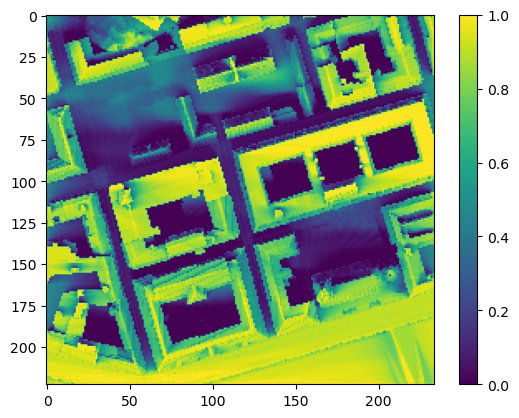

In [6]:
import matplotlib.pylab as plt
plt.imshow(fillraster)
plt.colorbar()

In [ ]:
saveraster(baseraster, '/home/joona/Documents/umeppi/output/Shadow_Aggregated.tif', fillraster)